Here we look into implied volatility and volatility smiles and surface, on NASDAQ option prices.

We first process yahoo finance data using pandas, we compute the implied volatility using call prices, and plot the volatility smiles for deterministic days to maturity and deterministic strike prices, then merging these to plot our Volatility Surface.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
def get_yf_option_data(ticker):

    yfticker = yf.Ticker(ticker)
    expirationdates = yfticker.options #gets a list of available expiration dates for this underlying
    option_data = pd.DataFrame()

    for expiration in expirationdates:
        available_options = yfticker.option_chain(expiration) #creation of available_options Object
        calls = available_options.calls #creation of calls attribute to available_options
        calls['Option Type'] = "Call"
        puts = available_options.puts
        puts['Option Type'] = "Put"
        callputs = pd.concat([calls, puts]) #We create a dedicated dataframe where call & put options data are stored, easier to analyze
        #We need to add 23:59:59 to our pandas datetime object, to ensure we use the previous Close price as the EOD expiration price
        callputs['Expiration Date'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        option_data = pd.concat([option_data, callputs]) #Add the calls and puts data for the current expiration date, to the main option_data df
    option_data["Days to Maturity"] = (option_data['Expiration Date'] - dt.datetime.today()).dt.days + 1
    #the +1 ensures the current day is counted as well in our pandas dt.datetime / timedelta object
    return option_data

In [3]:
yfticker = "^NDX" #We will check NASDAQ

options_data = get_yf_option_data(yfticker)

# Select call options only, for implied vol computation
call_options_data = options_data[options_data["Option Type"] == "Call"]

# Print available expiration dates
print("Available Expiration Dates:")
print(set(options_data['Expiration Date']))

Available Expiration Dates:
{Timestamp('2024-11-21 23:59:59'), Timestamp('2025-08-15 23:59:59'), Timestamp('2025-03-21 23:59:59'), Timestamp('2024-12-02 23:59:59'), Timestamp('2024-12-31 23:59:59'), Timestamp('2024-11-22 23:59:59'), Timestamp('2024-11-26 23:59:59'), Timestamp('2024-12-06 23:59:59'), Timestamp('2025-09-19 23:59:59'), Timestamp('2025-06-30 23:59:59'), Timestamp('2024-11-29 23:59:59'), Timestamp('2024-12-03 23:59:59'), Timestamp('2024-11-15 23:59:59'), Timestamp('2025-01-03 23:59:59'), Timestamp('2025-02-21 23:59:59'), Timestamp('2025-01-17 23:59:59'), Timestamp('2024-11-14 23:59:59'), Timestamp('2024-11-12 23:59:59'), Timestamp('2025-04-17 23:59:59'), Timestamp('2025-09-30 23:59:59'), Timestamp('2024-11-18 23:59:59'), Timestamp('2025-06-20 23:59:59'), Timestamp('2024-12-27 23:59:59'), Timestamp('2024-11-25 23:59:59'), Timestamp('2025-03-31 23:59:59'), Timestamp('2026-12-18 23:59:59'), Timestamp('2024-12-12 23:59:59'), Timestamp('2025-07-18 23:59:59'), Timestamp('2024-11-

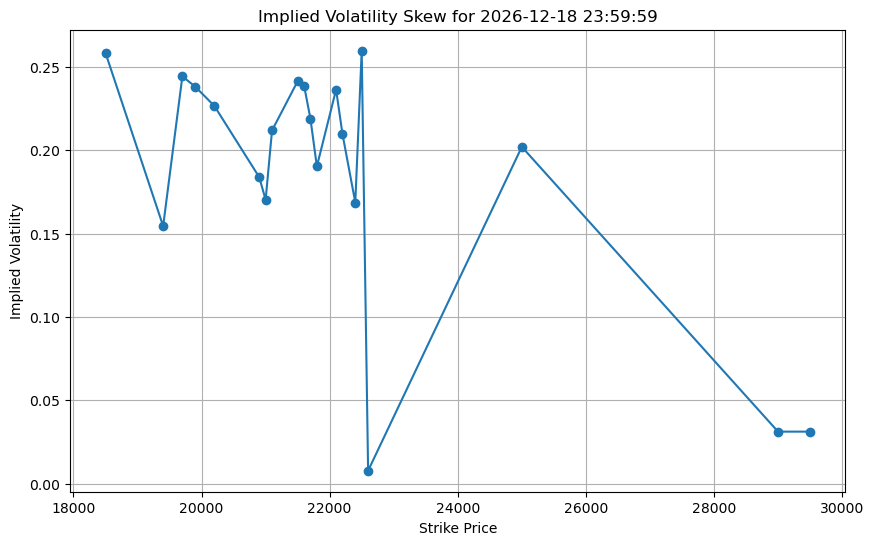

In [4]:
# Select an expiration date and plot implied volatility based on option prices
chosen_expiry = "2026-12-18 23:59:59"
calls_raw_at_chosen_expiry = call_options_data[call_options_data["Expiration Date"] == chosen_expiry]

# We remove low implied volatility options (low trading activity/deep OTM leading to less robust / noisy data)
calls_at_expiry = calls_raw_at_chosen_expiry[calls_raw_at_chosen_expiry["impliedVolatility"] >= 0.005]

# Set the strike price as the index for better plotting
calls_at_expiry.set_index("strike", inplace=True)
# Plot Implied Volatility Skew
plt.figure(figsize=(10, 6))
plt.plot(calls_at_expiry.index, calls_at_expiry["impliedVolatility"], marker='o', linestyle='-')
plt.title(f"Implied Volatility Skew for {chosen_expiry}")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.grid(True)

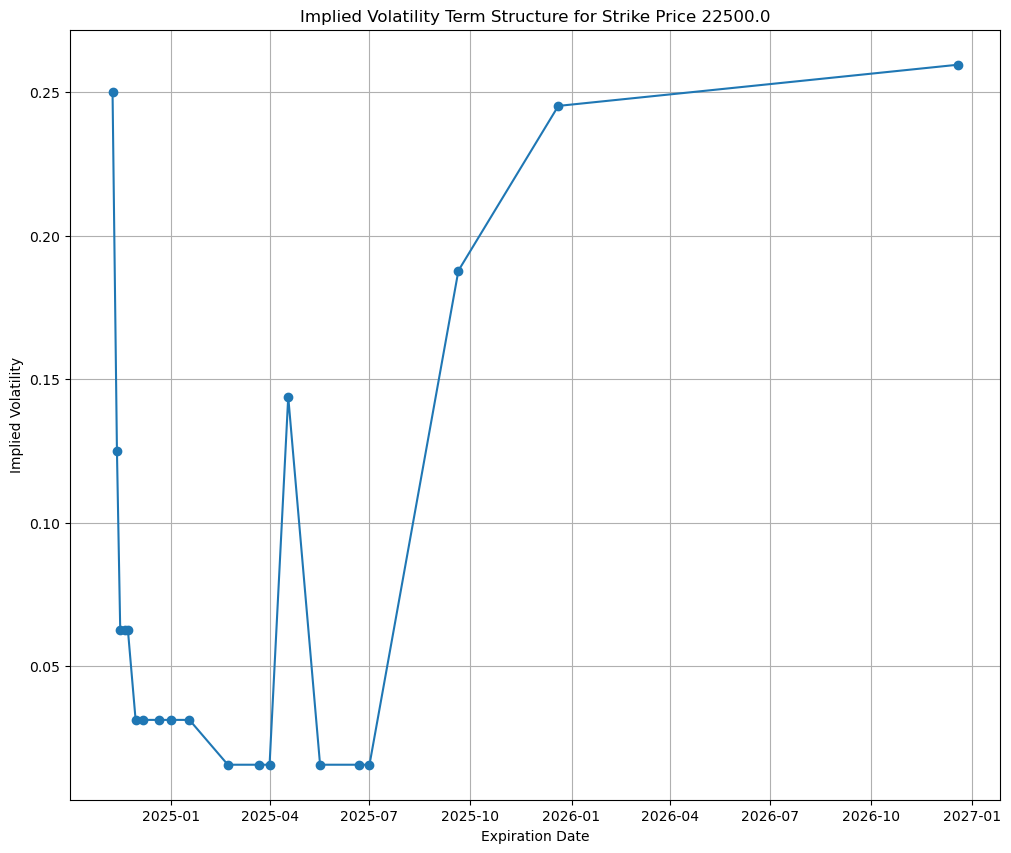

In [5]:
# Select a specific strike price to plot implied volatility based on option prices
chosen_strike = 22500.0
calls_raw_at_chosen_strike = call_options_data[call_options_data["strike"] == chosen_strike]

# Filter out low implied volatility options
filtered_calls_at_strike = calls_raw_at_chosen_strike[calls_raw_at_chosen_strike["impliedVolatility"] >= 0.005]
# Set the expiration date as the index for better plotting
filtered_calls_at_strike.set_index("Expiration Date", inplace=True)

# Plot Implied Volatility Term Structure
plt.figure(figsize=(12, 10))
plt.plot(filtered_calls_at_strike.index, filtered_calls_at_strike["impliedVolatility"], marker='o', linestyle='-')
plt.title(f"Implied Volatility Term Structure for Strike Price {chosen_strike}")
plt.xlabel("Expiration Date")
plt.ylabel("Implied Volatility")
plt.grid(True)

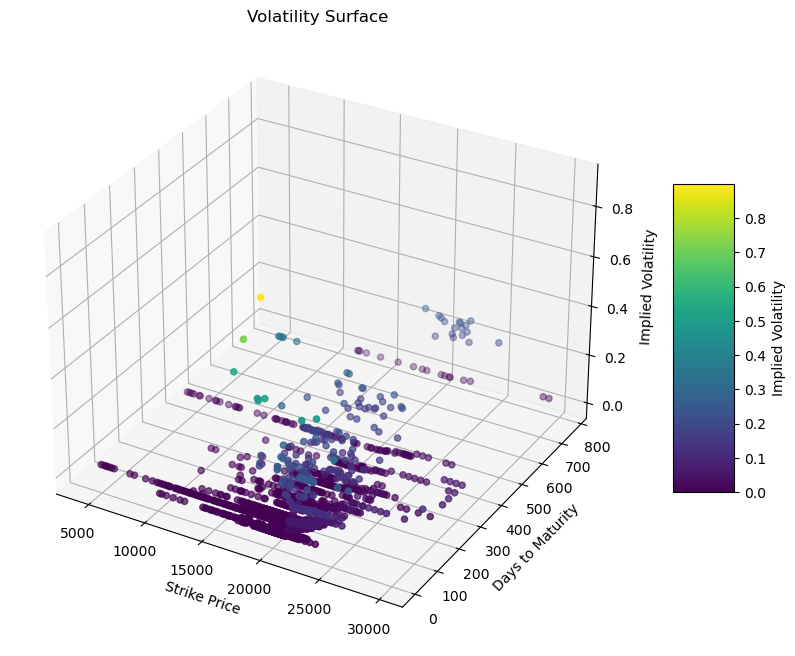

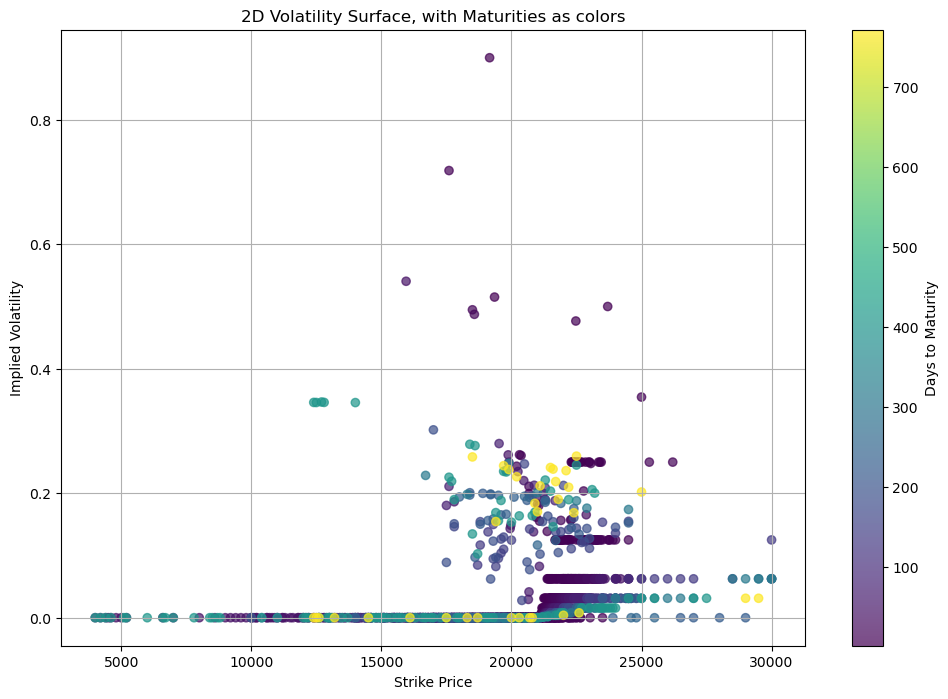

In [6]:

# Get relevant columns for plotting
strikes = call_options_data['strike']
days_to_maturity = call_options_data['Days to Maturity']
implied_volatility = call_options_data['impliedVolatility']

# 3D plotting of Volatility Surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(strikes, days_to_maturity, implied_volatility, c=implied_volatility, cmap='viridis')

# Set plot labels and title
ax.set_xlabel('Strike Price')
ax.set_ylabel('Days to Maturity')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface')

# Add implied vol color bar legend
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Implied Volatility')

plt.show()

# 2D Scatter Plot (Implied Volatility vs Strike Price)
plt.figure(figsize=(12, 8))
plt.scatter(strikes, implied_volatility, c=days_to_maturity, cmap='viridis', alpha=0.7)
plt.colorbar(label='Days to Maturity')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('2D Volatility Surface, with Maturities as colors')
plt.grid(True)
plt.show()
